# Data Analysis

The notebook details the process of EDA and analysis of the merged datasets.

## Content (Visuals)
- heat map showing spearman(?) correlation
- bivariate Geographical map showing mh score and some impactful environmental feature at either the state or division
level, with indicators for states that have few rows in our cleaned dataset
- mental health scores for our city comparisons
- Maybe a pairplot(?) showing correlations between features but we need to decide which <10 features to include in that pairplot

## Cities with similar environmental features
visual will be multi subplots choropleth map that presenting their `mh_score`.

In [23]:
import map_module as map
import file_path as path
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

from generativepy.color import Color
from PIL import ImageColor

import pandas as pd

In [9]:
# combine city_geo_file and merged_data_file
geo_data = path.geo_us_file
merged_data = path.merged_data_file

mh_score_df, _ = map.df_manipulation_for_bimap(geo_data, merged_data, 'Longitude',other_features = ['State','Urban Center'], lefton='UC_Grouping', righton='UC_Grouping',mh_feature='MH_Score', percentile = np.linspace(0.33, 1, 3), color_list=['#ffb000', '#dc267f', '#648fff', '#785ef0'],
    env_color_01 = 'c1_env',
    mh_col = 'MH_Score',
    mh_color_02 = 'c2_mh')


In [13]:
print(type(mh_score_df))
mh_score_df.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,MH_Score,Longitude,State,Urban Center,c1_env,c2_mh
0,"MULTIPOLYGON (((-158.01244 21.42219, -157.9915...",0.052083,0.000000,HI,Honolulu,2,2
1,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411...",0.656250,0.427609,CA,Santa Maria,1,1


In [213]:
def hex_to_Color(hexcode):
    """
    Helping function to convert hex color codes to rgb to Color object
    """
    rgb = ImageColor.getcolor(hexcode, "RGB")
    rgb = [v / 255 for v in rgb]  # normalize RGB values to [0,1] for matplotlib
    rgb = Color(
        *rgb
    )  # * unpacks the list into arguments, converts RGB values to Color object
    return rgb  # color object is stored in rgba(4 values) format


def mono_mikhailsirenko_colorscale(
    percentile = np.linspace(0.2, 1, 5),
    color_list=['#808080', '#FF0000']
):
    """
    Creating color gradient list for bivariate choropleth map legend

    Code from Mikhail Sirenko, slightly modified to fit our project
    More information: https://github.com/mikhailsirenko/bivariate-choropleth/blob/main/bivariate-choropleth.ipynb

    """

    # basic colors for the gradient
    c00 = hex_to_Color(color_list[0])
    c10 = hex_to_Color(color_list[1])

    # generate colorlist
    num_grps = len(percentile)
    # c00_to_c10 = []
    colorlist = []
    for i in range(num_grps):  # creating top and bottom horizontal color gradient
        # Using lerp to compute intermediate color between two colors at position t
        colorlist.append(c00.lerp(c10, 1 / (num_grps-1) * i))

    # convert colorlist(rgba) back to RGB values
    colorlist = [[c.r, c.g, c.b] for c in colorlist]

    color_list = np.array(colorlist).reshape(1, -1, 3)
    return color_list

In [214]:
c_lst = mono_mikhailsirenko_colorscale(
    percentile = np.linspace(0.2, 1, 5),
    color_list=['#0000FF', '#FF0000']
)
c_lst

array([[[0.  , 0.  , 1.  ],
        [0.25, 0.  , 0.75],
        [0.5 , 0.  , 0.5 ],
        [0.75, 0.  , 0.25],
        [1.  , 0.  , 0.  ]]])

In [65]:
def mono_assign_color_cells(
    df,
    mh_col = 'MH_Score',
    mh_color_02 = 'mh_color',
    percentile=np.linspace(0.25, 1, 4),
):
    """
    Assigning color index to the cells based on the percentile of the features
    """

    def assign_color_num(x):
        """
        Helping function to assign color index to the cells
        """
        for n in range(len(percentile)):
            if x <= percentile[n]:
                return len(percentile)-1 - n

    indf = df.copy()
    # indf[env_color_01] = indf[env_col].apply(lambda x: assign_color_num(x))
    indf[mh_color_02] = indf[mh_col].apply(lambda x: assign_color_num(x))
    return indf

In [64]:
mh_score_df.head(2)

,geometry,MH_Score,Longitude,State,Urban Center,c1_env,c2_mh
0,"MULTIPOLYGON (((-158.01244 21.42219, -157.9915...",0.052083,0.000000,HI,Honolulu,2,2
1,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411...",0.656250,0.427609,CA,Santa Maria,1,1


In [279]:
color_df = mono_assign_color_cells(mh_score_df, mh_col = 'MH_Score', mh_color_02 = 'mh_color', percentile=np.linspace(0.2, 1, 5))
color_df.sample(3)
Test_df = color_df[color_df['Urban Center'] == 'Flint'] 
Test_df

,geometry,MH_Score,Longitude,State,Urban Center,c1_env,c2_mh,mh_color
188,"MULTIPOLYGON (((-83.72529 43.10117, -83.68889 ...",0.90625,0.84692,MI,Flint,0,0,0


In [207]:
c_lst[0][Test_df['mh_color']][0].tolist()

[1.0, 0.0, 0.0]

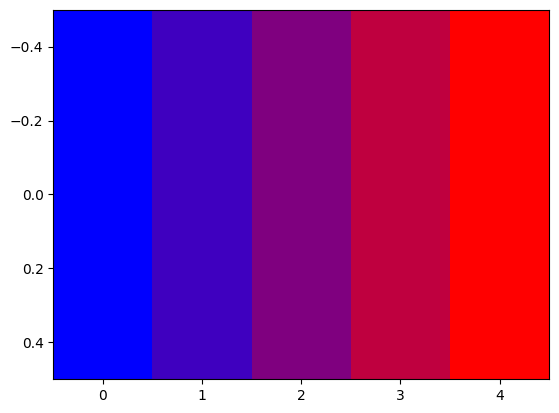

In [208]:
plt.imshow(c_lst, aspect="auto")

In [216]:
def map_urban_center(gdf, ax, urban_center, colorlist, mh_color_02 = 'mh_color',filter_col = 'Urban Center',edgecolor='black', linewidth=0.5, alpha=1):
    fil_df = gdf[gdf[filter_col] == urban_center]
    fil_df.plot(ax=ax, color= c_lst[0][fil_df['mh_color']][0].tolist(), alpha = alpha, edgecolor=edgecolor, linewidth=linewidth)
    cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

In [265]:
def bicolor_legend(ax,color_list,percentile = np.linspace(0.2, 1, 5),
    legend_position=[0.6, 0.7, 0.2, 0.2],
    tick_fontsize=6,
    label_fontsize=8,
    title = 'Mental Health Score',    
):
    """
    Insert bivariate choropleth map legend
    """
    ax = ax.inset_axes(legend_position)
    ax.set_aspect("equal", adjustable="box")

    ax.imshow(color_list)

    default_ticks = np.arange(0, len(percentile)+1, 1)
    adjusted_ticks = default_ticks - 0.5

    ax.set_xticks(adjusted_ticks)
    # ax.set_yticks(adjusted_ticks)

    ax.set_xticklabels([0] + [round(x,2) for x in percentile], fontsize=tick_fontsize)
    # ax.set_yticklabels(percentile[::-1].tolist() + [0], fontsize=tick_fontsize)

    ax.set_yticks([])
    ax.set_title(title, fontsize=label_fontsize, y = -0.7)
    return None

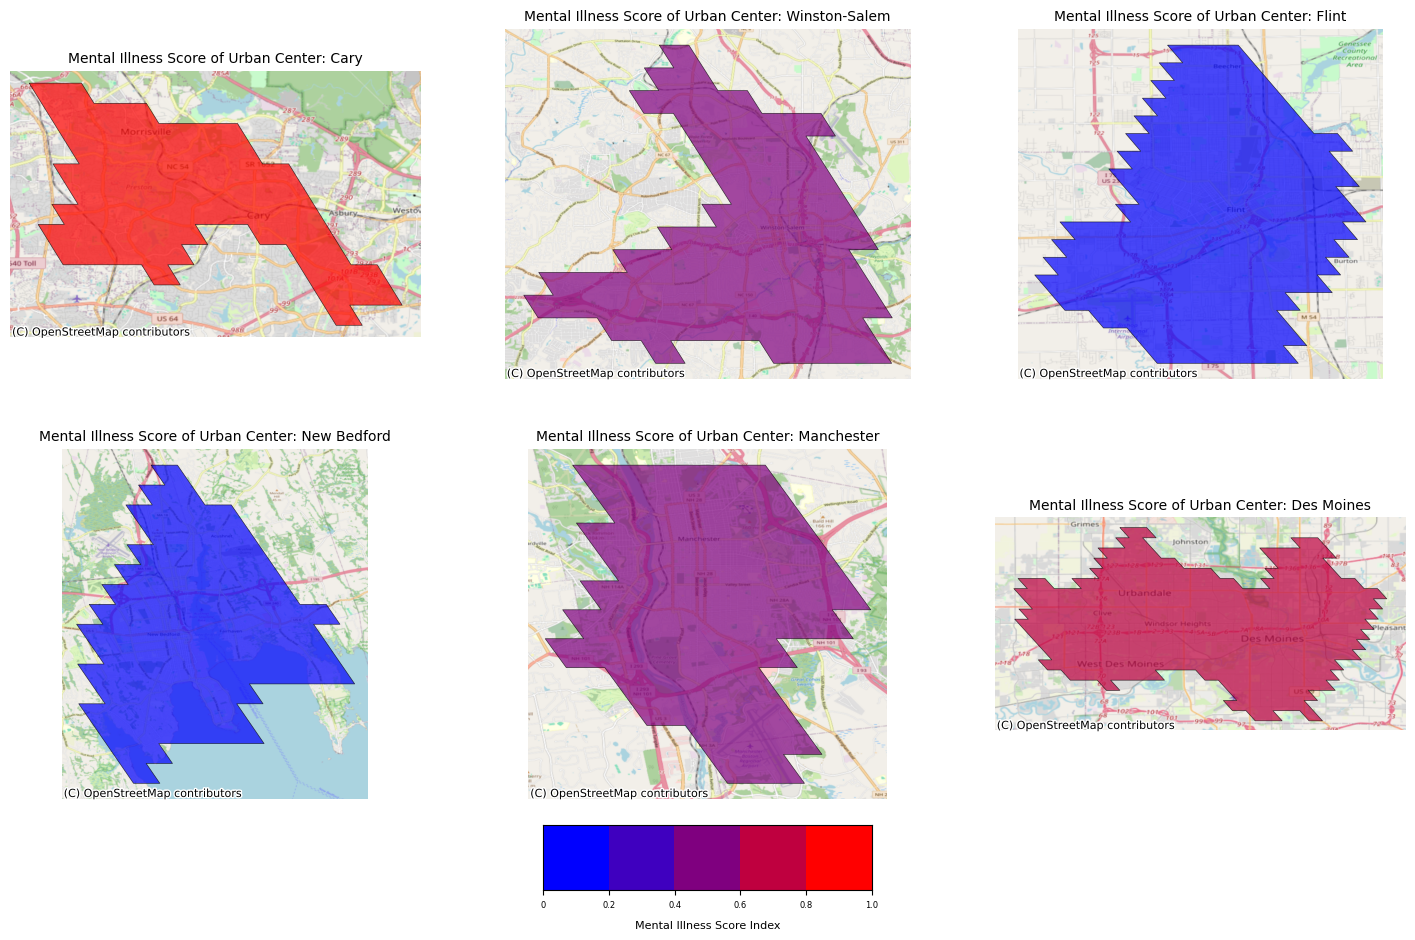

In [289]:
fig,ax = plt.subplots(2,3,figsize=(18,10))
map_urban_center(color_df, ax[0,0], 'Cary', c_lst,alpha=0.7,mh_color_02 = 'mh_color',filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map_urban_center(color_df, ax[0,1], 'Winston-Salem', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map_urban_center(color_df, ax[0,2], 'Flint', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map_urban_center(color_df, ax[1,0], 'New Bedford', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map_urban_center(color_df, ax[1,1], 'Manchester', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map_urban_center(color_df, ax[1,2], 'Des Moines', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)

map.set_off_axis(ax[0,0])
map.set_off_axis(ax[0,1])
map.set_off_axis(ax[0,2])
map.set_off_axis(ax[1,0])
map.set_off_axis(ax[1,1])
map.set_off_axis(ax[1,2])


ax[0,0].set_title('Mental Illness Score of Urban Center: Cary', fontsize=10)
ax[0,1].set_title('Mental Illness Score of Urban Center: Winston-Salem', fontsize=10)
ax[0,2].set_title('Mental Illness Score of Urban Center: Flint', fontsize=10)
ax[1,0].set_title('Mental Illness Score of Urban Center: New Bedford', fontsize=10)
ax[1,1].set_title('Mental Illness Score of Urban Center: Manchester', fontsize=10)
_= ax[1,2].set_title('Mental Illness Score of Urban Center: Des Moines', fontsize=10)



bicolor_legend(ax[1,2],c_lst,percentile = np.linspace(0.2, 1, 5),
    legend_position=[-1.1, -1, 0.8, 0.8],
    tick_fontsize=6,
    label_fontsize=8,
    title = 'Mental Illness Score Index',    
)